# OptOut Project Revision: Construct 18-year-long work sequences

For the newly enlarged sample

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from operator import itemgetter
from datetime import datetime

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Week-to-week crosswalk

Create two functions to convert between week number and calendar year and month

In [2]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_2012.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [3]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = weekdf[(weekdf['Week Start:\nMonth']==month)&(weekdf['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])

In [4]:
def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = weekdf[weekdf['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])

## Retrieve analytic sample

In [5]:
analytic_df = pd.read_csv('../data/analytic_df.csv') #includes fertility data
print analytic_df.shape
analytic_df.head()

(3378, 36)


,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,y_dob,m_dob,y_age35,y_deceased,last_yr,attr_before35,deceased_before35,y_child18,deceased_child18,attr_child18
0,2,5,3,2,3,1993,11,1994,-4,-4,...,1959,1,1994,NaN,2012,False,False,2011,False,False
1,3,5,3,2,6,1981,10,1983,4,1986,...,1961,8,1996,NaN,2012,False,False,1999,False,False
2,4,5,3,2,8,1980,3,1997,-4,-4,...,1962,8,1997,NaN,1998,False,False,1998,False,False
3,8,6,3,2,3,1976,5,1979,9,1982,...,1958,7,1993,NaN,2012,False,False,1994,False,False
4,16,5,3,2,2,1990,8,1993,9,1996,...,1958,10,1993,NaN,2012,False,False,2008,False,False


## Read weekly arrays and within-job gap dates

In [6]:
#read weekly array data
wkarray_df = pd.read_csv('../data/weeklyarrays.csv')
print wkarray_df.shape
print wkarray_df.columns[:20]

(12686, 3763)
Index([u'caseid_1979', u'sample_race_1979', u'sample_sex_1979',
       u'hrs_worked_wk_num0000_xrnd', u'hrs_worked_wk_num0001_xrnd',
       u'hrs_worked_wk_num0002_xrnd', u'hrs_worked_wk_num0003_xrnd',
       u'hrs_worked_wk_num0004_xrnd', u'hrs_worked_wk_num0005_xrnd',
       u'hrs_worked_wk_num0006_xrnd', u'hrs_worked_wk_num0007_xrnd',
       u'hrs_worked_wk_num0008_xrnd', u'hrs_worked_wk_num0009_xrnd',
       u'hrs_worked_wk_num0010_xrnd', u'hrs_worked_wk_num0011_xrnd',
       u'hrs_worked_wk_num0012_xrnd', u'hrs_worked_wk_num0013_xrnd',
       u'hrs_worked_wk_num0014_xrnd', u'hrs_worked_wk_num0015_xrnd',
       u'hrs_worked_wk_num0016_xrnd'],
      dtype='object')


In [7]:
#read within-job-gap data
gap_df = pd.read_csv("../data/withingaps.csv")
print gap_df.shape
print gap_df.columns[:20]

(12686, 807)
Index([u'caseid_1979', u'per1_start_1979_job01_xrnd',
       u'per1_start_1979_job02_xrnd', u'per1_start_1979_job03_xrnd',
       u'per1_start_1979_job04_xrnd', u'per1_start_1979_job05_xrnd',
       u'per1_stop_1979_job01_xrnd', u'per1_stop_1979_job02_xrnd',
       u'per1_stop_1979_job03_xrnd', u'per1_stop_1979_job04_xrnd',
       u'per1_stop_1979_job05_xrnd', u'per2_start_1979_job01_xrnd',
       u'per2_start_1979_job02_xrnd', u'per2_start_1979_job03_xrnd',
       u'per2_start_1979_job04_xrnd', u'per2_start_1979_job05_xrnd',
       u'per2_stop_1979_job01_xrnd', u'per2_stop_1979_job02_xrnd',
       u'per2_stop_1979_job03_xrnd', u'per2_stop_1979_job04_xrnd'],
      dtype='object')


In [8]:
#did young mother ever work before 1978? YES, some did
young_mom_df = analytic_df[analytic_df.c1dob_y_xrnd<1980]
print wkarray_df[wkarray_df.caseid_1979.isin(young_mom_df.caseid_1979)].hrs_worked_wk_num0000_xrnd.value_counts()

 0     710
 40     89
 30     13
 35     13
 20     11
 25      8
-3       7
 15      7
 50      6
 45      5
 32      4
 37      4
 10      3
 24      3
 8       3
 36      3
 42      3
 7       2
 38      2
 28      2
 72      2
 39      2
 18      2
 6       1
 5       1
 4       1
 12      1
 2       1
 16      1
 19      1
 22      1
 26      1
 33      1
 43      1
 48      1
 52      1
 55      1
 27      1
Name: hrs_worked_wk_num0000_xrnd, dtype: int64


## Identify maternity leaves

Maternity leave could cover the birth, start after the birth, or end before the birth. 

Let's assume any within-job gap that start or end within 4 months (16 weeks) of birth as maternity leave. There are relatively fewer maternity gaps that finished within 16 weeks before birth, so do not consider within-job gaps that ended within 16 weeks before birth as maternity leave.

### Does any of our respondents have gaps that started/ended prior to 1/1/1978? 

Three respondents had a within-job gap that started or ended prior to 1/1/1978. It is strange that respondent 1539 had a stop date prior to 1/1/1978, but did not report a start date prior to 1/1/978. 

Two of these respondents had first births after 1978, so these gaps that started/ended prior to 1/1/1978 won't produce any missing cases for them. Respondent 6587 gave first birth in 1974. She reported a job gap started before 1978, and the end date for the gap is missing (-3), and she worked 40 hours prior to 1/1/1978. She worked 40 hours, and there were 4 years between her birth and 1978. **Assume the gap is not maternity leave gap.** - <font color='red'>CONFIRM WITH SASHA</font>

In [10]:
merged = analytic_df.merge(gap_df, on='caseid_1979') # merge datasets
merged.columns

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd',
       ...
       u'per3_start_2012_job01_xrnd', u'per3_start_2012_job02_xrnd',
       u'per3_start_2012_job03_xrnd', u'per3_stop_2012_job01_xrnd',
       u'per3_stop_2012_job02_xrnd', u'per3_stop_2012_job03_xrnd',
       u'per4_start_2012_job01_xrnd', u'per4_start_2012_job02_xrnd',
       u'per4_stop_2012_job01_xrnd', u'per4_stop_2012_job02_xrnd'],
      dtype='object', length=842)

In [19]:
# count how many zero values in each job gap column

for col in merged.columns.tolist():
    if col.startswith('per'): # only check job gap columns
        count = sum(merged[col]==0)
        if count > 0:
            print col, count

per1_start_1979_job02_xrnd 1
per1_stop_1979_job01_xrnd 1
per2_start_1979_job02_xrnd 1


In [22]:
# who are the respondents with job gap weeks prior to 1/1/1978?
merged[merged.per1_start_1979_job02_xrnd==0]

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,per3_start_2012_job01_xrnd,per3_start_2012_job02_xrnd,per3_start_2012_job03_xrnd,per3_stop_2012_job01_xrnd,per3_stop_2012_job02_xrnd,per3_stop_2012_job03_xrnd,per4_start_2012_job01_xrnd,per4_start_2012_job02_xrnd,per4_stop_2012_job01_xrnd,per4_stop_2012_job02_xrnd
2193,6587,13,2,2,5,1974,1,1978,3,1982,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [23]:
merged[merged.per1_stop_1979_job01_xrnd==0]

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,per3_start_2012_job01_xrnd,per3_start_2012_job02_xrnd,per3_start_2012_job03_xrnd,per3_stop_2012_job01_xrnd,per3_stop_2012_job02_xrnd,per3_stop_2012_job03_xrnd,per4_start_2012_job01_xrnd,per4_start_2012_job02_xrnd,per4_stop_2012_job01_xrnd,per4_stop_2012_job02_xrnd
504,1539,6,3,2,12,1983,3,1986,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [24]:
merged[merged.per2_start_1979_job02_xrnd==0]

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,per3_start_2012_job01_xrnd,per3_start_2012_job02_xrnd,per3_start_2012_job03_xrnd,per3_stop_2012_job01_xrnd,per3_stop_2012_job02_xrnd,per3_stop_2012_job03_xrnd,per4_start_2012_job01_xrnd,per4_start_2012_job02_xrnd,per4_stop_2012_job01_xrnd,per4_stop_2012_job02_xrnd
2034,6114,13,2,2,11,1981,4,1986,8,1992,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [27]:
# when did these three women have first births? 
merged[merged.caseid_1979.isin([6587, 1359, 6114])][['caseid_1979', 'c1dob_y_xrnd']]

,caseid_1979,c1dob_y_xrnd
432,1359,1987
2034,6114,1981
2193,6587,1974


In [28]:
wkarray_df[wkarray_df.caseid_1979==6587]['hrs_worked_wk_num0000_xrnd']

6586    40
Name: hrs_worked_wk_num0000_xrnd, dtype: int64

### Write a function to retrieve all valid job gap start and end weeks

In [45]:
missing_data = defaultdict(list) # store missing information 

def get_gaps(row, d=missing_data):
    """
    Given a row of respondent data, 
    Return a list of tuples (start week, end week) of work gaps for respondent i
    """
    
    gap_row = gap_df[gap_df.caseid_1979==row['caseid_1979']].iloc[0]
    gaps = []
    
    #look for within-job gaps in all years. sometimes the gaps were recorded in later years
    for y in range(1979, 1995)+range(1996, 2013, 2): 
        for j in range(1, 5): #4 possible gap periods
            for k in range(1, 6): #5 possible jobs
                try: 
                    gap_start = gap_row['per%s_start_%s_job0%s_xrnd'%(j, y, k)]
                    gap_stop = gap_row['per%s_stop_%s_job0%s_xrnd'%(j, y, k)]
                    
                    if gap_start >= 0 and gap_stop >= 0:
                        gaps.append((gap_start, gap_stop))
                    elif gap_start == -4 and gap_stop == -4:
                        pass # valid skip
                    else:
                        missing_data['caseid_1979'].append(row['caseid_1979'])
                        missing_data['start_col'].append('per%s_start_%s_job0%s_xrnd'%(j, y, k))
                        missing_data['start'].append(gap_start) 
                        
                        start_y = None
                        start_m = None
                        if gap_start > 0:
                            start_y, start_m = get_year_month(gap_start)
                        missing_data['start_y'].append(start_y)
                        missing_data['start_m'].append(start_m)

                        missing_data['end_col'].append('per%s_stop_%s_job0%s_xrnd'%(j, y, k))
                        missing_data['end'].append(gap_stop)
                        
                        end_y = None
                        end_m = None
                        if gap_stop > 0:
                            end_y, end_m = get_year_month(gap_stop)
                        missing_data['end_y'].append(end_y)
                        missing_data['end_m'].append(end_m)

                        print 'missing data - id:', row['caseid_1979'], 'year:', y, 'gap #:', j, 'job #:', k, 'weeks: ', (gap_start, gap_stop)
                        
                except KeyError: # some years do not report 5 jobs
                    pass
                
    return gaps

In [46]:
res = analytic_df.apply(get_gaps, axis=1)

missing data - id: 3 year: 1987 gap #: 1 job #: 2 weeks:  (-3, -3)
missing data - id: 4 year: 1987 gap #: 2 job #: 1 weeks:  (471, -3)
missing data - id: 92 year: 1992 gap #: 2 job #: 1 weeks:  (750, -3)
missing data - id: 165 year: 1992 gap #: 2 job #: 1 weeks:  (752, -3)
missing data - id: 340 year: 2006 gap #: 3 job #: 1 weeks:  (1513, -2)
missing data - id: 395 year: 1988 gap #: 1 job #: 2 weeks:  (-3, -3)
missing data - id: 400 year: 2008 gap #: 1 job #: 2 weeks:  (1559, -2)
missing data - id: 444 year: 2012 gap #: 1 job #: 2 weeks:  (1695, -2)
missing data - id: 452 year: 1989 gap #: 1 job #: 2 weeks:  (579, -3)
missing data - id: 455 year: 1979 gap #: 3 job #: 2 weeks:  (2, -3)
missing data - id: 455 year: 1989 gap #: 1 job #: 2 weeks:  (582, -3)
missing data - id: 459 year: 2002 gap #: 1 job #: 1 weeks:  (1275, -2)
missing data - id: 582 year: 1989 gap #: 1 job #: 2 weeks:  (565, -3)
missing data - id: 582 year: 1990 gap #: 3 job #: 3 weeks:  (-3, 659)
missing data - id: 635 ye

In [47]:
miss_df = pd.DataFrame(missing_data)
miss_df.head()

,caseid_1979,end,end_col,end_m,end_y,start,start_col,start_m,start_y
0,3,-3,per1_stop_1987_job02_xrnd,NaN,NaN,-3,per1_start_1987_job02_xrnd,NaN,NaN
1,4,-3,per2_stop_1987_job01_xrnd,NaN,NaN,471,per2_start_1987_job01_xrnd,1.0,1987.0
2,92,-3,per2_stop_1992_job01_xrnd,NaN,NaN,750,per2_start_1992_job01_xrnd,5.0,1992.0
3,165,-3,per2_stop_1992_job01_xrnd,NaN,NaN,752,per2_start_1992_job01_xrnd,5.0,1992.0
4,340,-2,per3_stop_2006_job01_xrnd,NaN,NaN,1513,per3_start_2006_job01_xrnd,12.0,2006.0


In [48]:
# select only respondents who are in our sample
miss_df = miss_df[miss_df.caseid_1979.isin(analytic_df.caseid_1979.values.tolist())] 

# merge with childbirth dates
merged = miss_df.merge(analytic_df, on='caseid_1979')
merged.head()

,caseid_1979,end,end_col,end_m,end_y,start,start_col,start_m,start_y,sample_id_1979,...,y_dob,m_dob,y_age35,y_deceased,last_yr,attr_before35,deceased_before35,y_child18,deceased_child18,attr_child18
0,3,-3,per1_stop_1987_job02_xrnd,NaN,NaN,-3,per1_start_1987_job02_xrnd,NaN,NaN,5,...,1961,8,1996,NaN,2012,False,False,1999,False,False
1,4,-3,per2_stop_1987_job01_xrnd,NaN,NaN,471,per2_start_1987_job01_xrnd,1.0,1987.0,5,...,1962,8,1997,NaN,1998,False,False,1998,False,False
2,92,-3,per2_stop_1992_job01_xrnd,NaN,NaN,750,per2_start_1992_job01_xrnd,5.0,1992.0,5,...,1962,8,1997,NaN,2012,False,False,2000,False,False
3,165,-3,per2_stop_1992_job01_xrnd,NaN,NaN,752,per2_start_1992_job01_xrnd,5.0,1992.0,5,...,1960,10,1995,NaN,2012,False,False,2006,False,False
4,340,-2,per3_stop_2006_job01_xrnd,NaN,NaN,1513,per3_start_2006_job01_xrnd,12.0,2006.0,7,...,1962,12,1997,NaN,2012,False,False,1999,False,False


In [50]:
# what types of missing do we have? 
# both start and end missing? or only start or only end missing?

counts = defaultdict(list)

for i, row in merged.iterrows():
    
    if row['end'] < 0 and row['start'] < 0:
        counts['both missing'].append(i)
    elif row['end'] < 0 and row['start'] >= 0:
        counts['only end missing'].append(i)
    elif row['end'] >= 0 and row['start'] < 0:
        counts['only start missing'].append(i)
    else:
        print 'uncaptured:', row['start'], row['end']
        

for k, v in counts.items():
    print k, ':', len(v)

only start missing : 7
both missing : 163
only end missing : 132


In [60]:
# how many gaps happened in the same year as a childbirth? 38 cases

def same_year(row):
    """
    Return True if a gap year was reported in the same year as a childbirth 
    or started or ended in the sameyear as a childbirth
    """
    
    for i in range(1, 12):
        if row['c%idob_y_xrnd'%i] > 0:
            if str(row['c%idob_y_xrnd'%i]) in row['start_col']:
                return True
            elif str(row['c%idob_y_xrnd'%i]) in row['end_col']:
                return True
            elif row['c%idob_y_xrnd'%i] == row['start_y']:
                return True
            elif row['c%idob_y_xrnd'%i] == row['end_y']:
                return True
    return False


merged['same_year'] = merged.apply(same_year, axis=1)
merged.same_year.value_counts()

False    264
True      38
Name: same_year, dtype: int64

In [63]:
# What are the min number of months between the known start/end date and a childbirth?


def diff_month(d1, d2):
    """
    Return the number of months between the two dates
    """
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def min_months(row):
    """
    If a row has a valid starting week or a valid end week of a job gap, 
    calculate all of the differences in months bewteen the gap and all valid childbirths,
    return the min
    """
    
    diffs = []
    
    if row['start'] > 0:
        for i in range(1, 12):
            if row['c%idob_y_xrnd'%i] > 0:
                # a positive diff means birth happened after gap
                # a negative diff means birth happened before gap
                if row['c%idob_m_xrnd'%i] > 0:
                    diffs.append(diff_month(datetime(row['c%idob_y_xrnd'%i], row['c%idob_m_xrnd'%i], 1), 
                                            datetime(int(row['start_y']), int(row['start_m']), 1)))
                else: # assume June for respondent 8511
                    diffs.append(diff_month(datetime(row['c%idob_y_xrnd'%i], 6, 1), 
                                            datetime(int(row['start_y']), int(row['start_m']), 1)))
                    
            
    if row['end'] > 0:
        for i in range(1, 12):
            if row['c%idob_y_xrnd'%i] > 0:
                if row['c%idob_m_xrnd'%i] > 0:
                    diffs.append(diff_month(datetime(row['c%idob_y_xrnd'%i], row['c%idob_m_xrnd'%i], 1), 
                                            datetime(int(row['end_y']), int(row['end_m']), 1)))
                else:
                    diffs.append(diff_month(datetime(row['c%idob_y_xrnd'%i], 6, 1), 
                                            datetime(int(row['end_y']), int(row['end_m']), 1)))
            
    
    if len(diffs) == 0:
        return None
    else:
        return min(diffs, key=abs) # return the number with smallest magnitude, but preserve the sign
    
    
merged['min_months'] = merged.apply(min_months, axis=1)
merged.head()

,caseid_1979,end,end_col,end_m,end_y,start,start_col,start_m,start_y,sample_id_1979,...,y_age35,y_deceased,last_yr,attr_before35,deceased_before35,y_child18,deceased_child18,attr_child18,same_year,min_months
0,3,-3,per1_stop_1987_job02_xrnd,NaN,NaN,-3,per1_start_1987_job02_xrnd,NaN,NaN,5,...,1996,NaN,2012,False,False,1999,False,False,False,NaN
1,4,-3,per2_stop_1987_job01_xrnd,NaN,NaN,471,per2_start_1987_job01_xrnd,1.0,1987.0,5,...,1997,NaN,1998,False,False,1998,False,False,False,-77.0
2,92,-3,per2_stop_1992_job01_xrnd,NaN,NaN,750,per2_start_1992_job01_xrnd,5.0,1992.0,5,...,1997,NaN,2012,False,False,2000,False,False,True,-1.0
3,165,-3,per2_stop_1992_job01_xrnd,NaN,NaN,752,per2_start_1992_job01_xrnd,5.0,1992.0,5,...,1995,NaN,2012,False,False,2006,False,False,True,-1.0
4,340,-2,per3_stop_2006_job01_xrnd,NaN,NaN,1513,per3_start_2006_job01_xrnd,12.0,2006.0,7,...,1997,NaN,2012,False,False,1999,False,False,False,-222.0


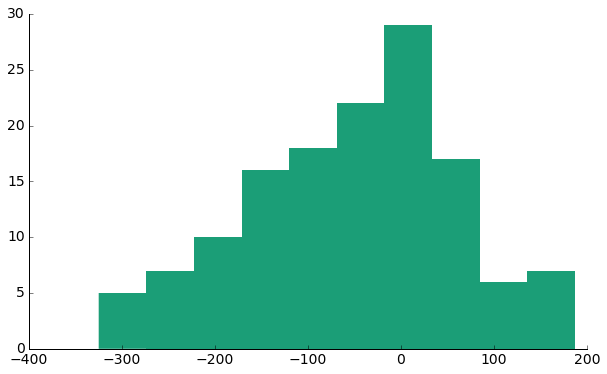

In [64]:
x = merged.min_months[~merged.min_months.isnull()] # remove missing
plt.hist(x)
remove_border()

In [66]:
# how many are within four months before birth?
merged[merged.min_months.isin([1, 2, 3, 4])].shape[0]

4

In [67]:
# how many are within four months after birth?
merged[merged.min_months.isin([-1, -2, -3, -4])].shape[0]

6

In [68]:
# how many overlap with birth?
merged[merged.min_months==0].shape[0]

2

Among all the 139 cases where we have only partial missing dates (either start or end week is known), very few (12 cases) took place within 4 months near a childbirth. <font color='red'>CONFIRM WITH SASHA: Is it okay to disregard all these missing gaps?</font>

In [69]:
# distribution of missing gaps per respondent (if a gap misses both start and end, count as 2 instances of missing)
merged.caseid_1979.value_counts()

7002     8
1446     5
746      4
6666     4
8869     4
1953     4
2669     4
11756    4
11989    4
2193     4
7158     4
5793     3
4185     3
5561     3
1225     3
7211     3
7302     3
7601     3
4766     2
10125    2
7997     2
6262     2
582      2
3738     2
5127     2
4959     2
8103     2
8354     2
4974     2
9817     2
        ..
12029    1
8953     1
5624     1
3317     1
7981     1
1839     1
6448     1
3889     1
1419     1
4464     1
1900     1
4971     1
2407     1
9206     1
9381     1
3423     1
862      1
2396     1
6489     1
340      1
5459     1
8315     1
3407     1
5453     1
4428     1
836      1
2369     1
5428     1
4447     1
3073     1
Name: caseid_1979, dtype: int64

### When did respondent 8511's gaps happen? 

She had month msising for her 4th birth in 2001. None of her gap happened in that year. In fact, she never had any leaves around childbirth.

In [31]:
# check respondent caseid 8511
get_gaps(8511)

[(104, 106)]

In [32]:
print get_year_month(104), get_year_month(106)

(1979, 12) (1980, 1)


In [19]:
# when did respondent 8511 have birth?
analytic_df[analytic_df.caseid_1979==8511]

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,c11dob_y_xrnd,y_dob,y_age35,y_deceased,last_yr,attr_before35,deceased_before35,y_child18,deceased_child18,attr_child18
2739,8511,13,2,2,3,1990,11,1994,7,1998,...,-4,1962,1997,NaN,2012,False,False,2008,False,False


### Write a function to determine weeks of maternity leave - DISREGARD ALL MISSING GAPS FOR NOW

In [73]:
###modify to handle months prior to 1978


def get_gaps(row, d=missing_data): # copy the same function above, remove the part that deals with missing values
    """
    Given a row of respondent data, 
    Return a list of tuples (start week, end week) of work gaps for respondent i
    """
    
    gap_row = gap_df[gap_df.caseid_1979==row['caseid_1979']].iloc[0]
    gaps = []
    
    #look for within-job gaps in all years. sometimes the gaps were recorded in later years
    for y in range(1979, 1995)+range(1996, 2013, 2): 
        for j in range(1, 5): #4 possible gap periods
            for k in range(1, 6): #5 possible jobs
                try: 
                    gap_start = gap_row['per%s_start_%s_job0%s_xrnd'%(j, y, k)]
                    gap_stop = gap_row['per%s_stop_%s_job0%s_xrnd'%(j, y, k)]
                    
                    if gap_start >= 0 and gap_stop >= 0:
                        gaps.append((gap_start, gap_stop))
                    elif gap_start == -4 and gap_stop == -4:
                        pass # valid skip
                    else:
                        pass
#                         missing_data['caseid_1979'].append(row['caseid_1979'])
#                         missing_data['start_col'].append('per%s_start_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['start'].append(gap_start) 
                        
#                         start_y = None
#                         start_m = None
#                         if gap_start > 0:
#                             start_y, start_m = get_year_month(gap_start)
#                         missing_data['start_y'].append(start_y)
#                         missing_data['start_m'].append(start_m)

#                         missing_data['end_col'].append('per%s_stop_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['end'].append(gap_stop)
                        
#                         end_y = None
#                         end_m = None
#                         if gap_stop > 0:
#                             end_y, end_m = get_year_month(gap_stop)
#                         missing_data['end_y'].append(end_y)
#                         missing_data['end_m'].append(end_m)

#                         print 'missing data - id:', row['caseid_1979'], 'year:', y, 'gap #:', j, 'job #:', k, 'weeks: ', (gap_start, gap_stop)
                        
                except KeyError: # some years do not report 5 jobs
                    pass
                
    return gaps


def find_maternal_leave_no_before(row):
    """
    Given a row of respondent data, return a list of all weeks identified as maternal leaves
    """
    
    leaves = []
    
    gaps = get_gaps(row)
    
    for j in range(1, 12): # all births
        dob_y = row['c%idob_y_xrnd'%j]
        dob_m = row['c%idob_m_xrnd'%j]
        
        if dob_y>0 and dob_m>0:
            
            #modification: job gap dates do not go prior to 1978
            # we only had one person who possibly had a job gap around birth time prior to 1/1/1978, 
            # but she only worked 40 hours pre-1978, so assume no maternity leave
            
            if dob_y>=1978: 
                
                for (gap_start, gap_stop) in gaps:
                    birth_wks = range(get_week_num(dob_y, dob_m, 'first'), get_week_num(dob_y, dob_m, 'last')+1)
                    gap_wks = range(gap_start, gap_stop+1)
                    is_ma_leave = False

                    if set(birth_wks)&set(gap_wks): #the gap took place in the month of the birth
                        is_ma_leave = True

                    elif gap_start>birth_wks[-1] and gap_start-birth_wks[-1]<=16: #gap started within 16 weeks after birth
                        is_ma_leave = True

                    if is_ma_leave:
                        leaves += range(gap_start, gap_stop+1)
    
    return leaves

## Tranform weekly sequences

My status classification scheme:

* 1 - full-time employment
* 2 - working with missing hours
* 3 - part-time employent
* 4 - nonwokring 
* 5 - maternity leave


NEW: If respondents reported working 0 hours in week 0 (total hours worked pre-1978), assign 4-nonworking to all weeks before week 1. 

In [76]:
#select only week array data for our selected sample
merged_wkarray_df = analytic_df.merge(wkarray_df, on='caseid_1979')
print merged_wkarray_df.shape

(3378, 3798)


### How to handle work hour 0? Should it count as part-time? How many monthly status will be affected if we could or do not count it as part-time?

In [78]:
# what labor force status are associated with work hour 0?

# Create a dictionary to store counts
counts = defaultdict(list)

for i, row in merged_wkarray_df.iterrows(): #iterate through weekly array rows

    #keep track of progress
    if i%100 == 0: 
        print i
    
    #find year and month of first childbirth
    dob_y = row['c1dob_y_xrnd']
    dob_m = row['c1dob_m_xrnd']
    
    #find employment sequence start year and month
    if dob_m == 12:
        start_y = dob_y+1
        start_m = 1
    else:
        start_y = dob_y
        start_m = dob_m+1
        
    #maternal leaves
    leaves = find_maternal_leave_no_before(row)
        
    for week_num in range(1, 1880): #iterate through all weekly work variables
         
        #if the week is maternity leave
        if week_num in leaves:
            continue
        
        #otherwise:
        my_status = None
        
        #get the hours worked this week 
        hours = row['hrs_worked_wk_num%04d_xrnd'%week_num]
    
        #get the employment status this week
        status = row['status_wk_num%04d_xrnd'%week_num]

        if (status >= 100 and status <= 2510):
            status = 'w' #working
        
        if hours == 0:
            counts[status].append(row['caseid_1979'])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300


In [81]:
print 'display freq of labor force status associated with work hour 0 (i.e. number of weeks)'
for k, v in counts.items():
    print k, ':', len(v)    
    
print
print 'display number of unique respondents in each labor force status associated with work hour 0'
for k, v in counts.items():
    print k, ':', len(set(v))    

display freq of labor force status associated with work hour 0 (i.e. number of weeks)
0 : 404425
2 : 29233
4 : 303358
5 : 1741711
7 : 11214
w : 4752

display number of unique respondents in each labor force status associated with work hour 0
0 : 3378
2 : 838
4 : 3180
5 : 3344
7 : 50
w : 95


In [82]:
### modification: assign a unique status (99) to weeks with labor force status 'w' and work hour 0


# Create a dictionary to store data
data = defaultdict(list)

# count how many hours people work with employment status 3 (associated with employer)
count_hrs_status3 = []

for i, row in merged_wkarray_df.iterrows(): #iterate through weekly array rows

    #keep track of progress
    if i%100 == 0: 
        print i
    
    #find year and month of first childbirth
    dob_y = row['c1dob_y_xrnd']
    dob_m = row['c1dob_m_xrnd']
    
    #find employment sequence start year and month
    if dob_m == 12:
        start_y = dob_y+1
        start_m = 1
    else:
        start_y = dob_y
        start_m = dob_m+1
    
    
    #keep three columns: id, start_y, start_m
    data['id'].append(row['caseid_1979'])
    data['start_y'].append(start_y)
    data['start_m'].append(start_m) 
        
    #maternal leaves
    leaves = find_maternal_leave_no_before(row)
        
    for week_num in range(1, 1880): #iterate through all weekly work variables
         
        #if the week is maternity leave
        if week_num in leaves:
            data['week%s'%week_num].append(5) 
            continue
        
        #otherwise:
        my_status = None
        
        #get the hours worked this week 
        hours = row['hrs_worked_wk_num%04d_xrnd'%week_num]
    
        #get the employment status this week
        status = row['status_wk_num%04d_xrnd'%week_num]

        if (status >= 100 and status <= 2510):
            status = 'w' #working
        
        if hours >= 35:
            hours = 'ft' #full-time working hours
        elif hours > 0 and hours < 35:
            hours = 'pt' #part-time working hours
        
        
        ### define employment status according to my classification scheme ###
        
        # missing
        if hours == 0 and status == 0:
            my_status = 0
            
        # full time
        elif hours == 'ft' and status in ['w', 3]:
            my_status = 1
        elif hours == 0 and status == 7:
            my_status = 1
            
        # working, missing hours
        elif hours < 0 and status in ['w', 3]: 
            my_status = 2
            
            ###################
            if status==3:
                count_hrs_status3.append(hours)
            
        # part time
        elif hours == 'pt' and status in ['w', 3]:
            my_status = 3
            
        ### NEW ###
        elif hours == 0 and status == 'w':
            my_status = 99
            
        # non-working
        elif hours <= 0 and status == 2:
            my_status = 4
        elif hours <= 0 and status == 4:
            my_status = 4
        elif hours <= 0 and status == 5:
            my_status = 4

        else:
            raise Exception, 'unknown hours and status: (%s, %s)'%(hours, status)
            
        data['week%s'%week_num].append(my_status) #make the week number start from 0, easier for indexing in Python

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300


In [83]:
#create the new weekly array dataframe with my edited employment status

#week number range: 1 - 1879

#order the columns in the new dataframe
cols = ['id', 'start_y', 'start_m'] + ['week%s'%n for n in range(1, 1880)]

full_df = pd.DataFrame(data, columns=cols)
print full_df.iloc[0]

id             2
start_y     1993
start_m        4
week1          4
week2          4
week3          4
week4          4
week5          4
week6          4
week7          4
week8          4
week9          4
week10         4
week11         4
week12         4
week13         4
week14         4
week15         4
week16         4
week17         4
week18         4
week19         1
week20         1
week21         1
week22         1
week23         1
week24         1
week25         1
week26         1
week27         1
            ... 
week1850       0
week1851       0
week1852       0
week1853       0
week1854       0
week1855       0
week1856       0
week1857       0
week1858       0
week1859       0
week1860       0
week1861       0
week1862       0
week1863       0
week1864       0
week1865       0
week1866       0
week1867       0
week1868       0
week1869       0
week1870       0
week1871       0
week1872       0
week1873       0
week1874       0
week1875       0
week1876       0
week1877      

In [84]:
#how many times did status 3 appear?
print len(count_hrs_status3)

826


In [85]:
#what work hours are associated with status 3?
set(count_hrs_status3)

{-3}

In [86]:
# export to csv
full_df.to_csv('../data/full_wk_df.csv', index=False)

## Construct 18-year monthly sequences

In [88]:
def find_modal(l):
    """
    Given a list l, return the most common element in the list. 
    if there is a tie, return all elements.
    """
    
    #first, count frequency of each unique item in the list
    counter = defaultdict(int)
    for item in l:
        counter[item] += 1

    #rank items from most frequent to least frequent
    popular_items = sorted(counter, key=counter.get, reverse = True)
    
    most_common = [popular_items[0]]
    
    for other in popular_items[1:]:
        if counter[other] < counter[most_common[0]]:
            break
        elif counter[other] == counter[most_common[0]]: #find an equally frequent item
            most_common.append(other)
        else:
            print 'impossible'

    return most_common

#for example
print find_modal([1, 1, 2, 1, 5])
print find_modal([1, 1, 2, 1, 5, 2, 2, 33])

[1]
[1, 2]


### Version 1: treat work hour 0 as 'working, with missing hours'

In [90]:
import random
random.seed(7222014)

res_data = defaultdict(list) #create an empty dictionary to store data

count_ties = [] #how many we get ties of modal, store a tuple (respondent id, month # where a tie occured) 

for i, row in full_df.iterrows():
    
    # keep track of progress
    if i%100 == 0:
        print i
    
    # keep basic info: id, sequence start year and month
    res_data['id'].append(row['id'])
    
    y = row['start_y']
    m = row['start_m']
    
    res_data['start_y'].append(y)
    res_data['start_m'].append(m)
    
    
    # look at weekly statuses
    for j in range(1, 217): # from month 1 to month 216
        
        if y < 1978: #prior to 1978
            hrs_pre1978 = merged_wkarray_df[merged_wkarray_df.caseid_1979==row['id']].iloc[0]['hrs_worked_wk_num0000_xrnd']
            
            if hrs_pre1978 == 0: # never worked before 1978
                res_data['month%s'%j].append(4) # assign 4 - nonemployed
            else:
                res_data['month%s'%j].append(0) # otherwise, assign missing
            
        else:
            start = get_week_num(y, m, 'first')
            end = get_week_num(y, m, 'last')
            wk_statuses = [row['week%i'%k] for k in range(start, end+1)]
            
            #### replace 99 (work hour 0) as status 2 (working, with missing hours) ####
            wk_statuses = [v if v != 99 else 2 for v in wk_statuses]

            #find unique items in the given month 
            distinct = list(set(wk_statuses))
            distinct.sort()

            if len(distinct) == 1:
                res_data['month%s'%j].append(distinct[0])

            elif len(distinct) >= 2:
                modal = find_modal(wk_statuses)
                if len(modal) == 1:
                    res_data['month%s'%j].append(modal[0])
                else:
                    res_data['month%s'%j].append(random.choice(modal))
                    count_ties.append((row['id'], j))

         
        #move to next month
        if m < 12:
            m += 1
        elif m == 12:
            m = 1
            y += 1

cols = ['id', 'start_y', 'start_m'] + ['month%s'%i for i in range(1, 217)]
res_df = pd.DataFrame(res_data, columns=cols) #restricted dataframe

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300


In [91]:
print "%s instances of ties"%len(count_ties)

ids = map(itemgetter(0), count_ties)
print "%s unique respondents have ties"%len(set(ids))

5769 instances of ties
2381 unique respondents have ties


### Version 2: treat work hour 0 as 'part-time'

In [ ]:
import random
random.seed(7222014)

res_data2 = defaultdict(list) #create an empty dictionary to store data

count_ties2 = [] #how many we get ties of modal

for i, row in full_df.iterrows():
    
    # keep track of progress
    if i%100 == 0:
        print i
    
    # keep basic info: id, sequence start year and month
    res_data2['id'].append(row['id'])
    
    y = row['start_y']
    m = row['start_m']
    
    res_data2['start_y'].append(y)
    res_data2['start_m'].append(m)
    
    
    # look at weekly statuses
    for j in range(1, 217): # from month 1 to month 216
        
        if y < 1978: #prior to 1978
            hrs_pre1978 = merged_wkarray_df[merged_wkarray_df.caseid_1979==row['id']].iloc[0]['hrs_worked_wk_num0000_xrnd']
            
            if hrs_pre1978 == 0: # never worked before 1978
                res_data2['month%s'%j].append(4) # assign 4 - nonemployed
            else:
                res_data2['month%s'%j].append(0) # otherwise, assign missing
            
        else:
            start = get_week_num(y, m, 'first')
            end = get_week_num(y, m, 'last')
            wk_statuses = [row['week%i'%k] for k in range(start, end+1)]
            
            #### modification ####
            if not 99 in wk_statuses: # directly use the monthly status derived before
                status = res_df[res_df.id==row['id']].iloc[0]['month%s'%j]
                res_data2['month%s'%j].append(status)
            else:            
                #### replace 99 (work hour 0) as status 3 (part-time) ####
                wk_statuses = [v if v != 99 else 3 for v in wk_statuses]

                #find unique items in the given month 
                distinct = list(set(wk_statuses))
                distinct.sort()

                if len(distinct) == 1:
                    res_data2['month%s'%j].append(distinct[0])

                elif len(distinct) >= 2:
                    modal = find_modal(wk_statuses)
                    if len(modal) == 1:
                        res_data2['month%s'%j].append(modal[0])
                    else:
                        res_data2['month%s'%j].append(random.choice(modal))
                        count_ties2.append((row['id'], j))

         
        #move to next month
        if m < 12:
            m += 1
        elif m == 12:
            m = 1
            y += 1

cols = ['id', 'start_y', 'start_m'] + ['month%s'%i for i in range(1, 217)]
res_df2 = pd.DataFrame(res_data2, columns=cols) #restricted dataframe

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


In [ ]:
print "%s instances of ties"%len(count_ties)
print "%s unique respondents have ties"%len(set(count_ties))

### Export both to csv for now

In [28]:
res_df.to_csv("../data/monthly_df.csv", index=False)
res_df2.to_csv("../data/monthly_df2.csv", index=False)

### Compare two versions of monthly sequences

Some of their differences come from the random selection of multiple most frequent statuses.

In [ ]:
diff = res_df[['month%s'%i for i in range(1, 217)]]

for i in range(1, 217):
    diff['month%s'%i] = res_df['month%s'%i] != res_df2['month%s'%i]

In [ ]:
diff_by_col = diff.apply(lambda col: sum(col), axis=0)
plt.hist(diff_month_by_col.iloc[0].values)
remove_border()

# Explore the sequences

* Version 1: treat work hour 0 as 'working, with missing hours'
* Version 2: treat work hour 0 as 'part-time'

### Explore distribution of status 0 - completely missing

In [29]:
def has_missing(row):
    vals = [row['month%s'%i]==0 for i in range(1, 217)]
    return sum(vals)

num_missings = res_df.apply(has_missing, axis=1)
num_missings2 = res_df.apply(has_missing2, axis=1)

In [ ]:
print "Verzion 1: %s respondents have no missing"%sum([v==0 for v in num_missings])
print "Verzion 2: %s respondents have no missing"%sum([v==0 for v in num_missings2])

In [ ]:
# mean and median of missing months per respondent (after removing cases with no missing)
print 'version 1:', np.mean([v for v in num_missings if v>0]), np.median([v for v in num_missings if v>0])
print 'version 2:', np.mean([v for v in num_missings2 if v>0]), np.median([v for v in num_missings2 if v>0])

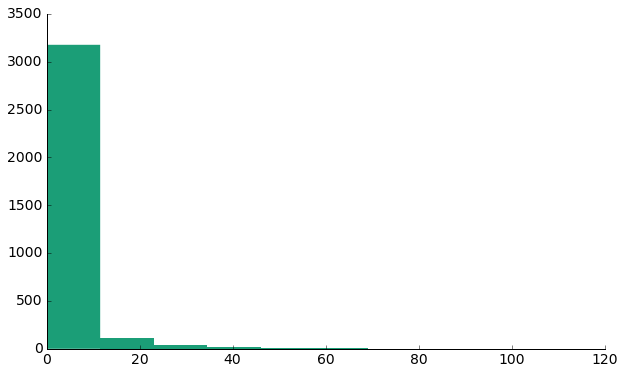

In [30]:
# plot after removing cases with no missing
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist([v for v in num_missings if v>0])
ax1.set_title("Version 1: treat work hour 0 as 'working, with missing hours'")
ax2.hist([v for v in num_missings2 if v>0])
ax2.set_title("Version 2: treat work hour 0 as 'part-time'")

### Explore distribution of status 2 - work, with missing hours

In [ ]:
def has_missing_hours(row):
    vals = [row['month%s'%i]==2 for i in range(1, 217)]
    return sum(vals)

num_missings = res_df.apply(has_missing, axis=1)
num_missings2 = res_df.apply(has_missing2, axis=1)

In [ ]:
print "Verzion 1: %s respondents have no missing hour"%sum([v==0 for v in num_missings])
print "Verzion 2: %s respondents have no missing hour"%sum([v==0 for v in num_missings2])

In [ ]:
# mean and median of missing months per respondent (after removing cases with no missing hour)
print 'version 1:', np.mean([v for v in num_missings if v>0]), np.median([v for v in num_missings if v>0])
print 'version 2:', np.mean([v for v in num_missings2 if v>0]), np.median([v for v in num_missings2 if v>0])

In [ ]:
# plot after removing cases with no missing hour
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist([v for v in num_missings if v>0])
ax1.set_title("Version 1: treat work hour 0 as 'working, with missing hours'")
ax2.hist([v for v in num_missings2 if v>0])
ax2.set_title("Version 2: treat work hour 0 as 'part-time'")